# Ruteo

In [1]:
import pandas as pd
import numpy as np
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import random
import time
import networkx as nx

In [2]:
distancias_poligonos = pd.read_csv('distancias_reducidas_19_poligonos.csv')
distancias_poligonos.head(5)

,1,3,4,5,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,0.000000,9.219544,6.500000,6.500000,27.115494,27.658633,30.103986,31.531730,34.731110,33.320414,31.953091,31.674122,31.064449,37.396524,43.410828,41.382363,40.205721,39.080046,36.912100
1,9.219544,0.000000,4.500000,9.500000,25.831183,24.698178,25.811819,30.761177,26.196374,25.144582,24.331050,25.005000,25.495098,36.776351,43.133500,33.203915,32.380550,31.752953,30.536863
2,6.500000,4.500000,0.000000,5.000000,23.021729,22.655022,24.515301,27.802878,28.301943,26.832816,25.460754,25.317978,25.005000,33.811980,40.078049,34.889110,33.708308,32.626676,30.647186
3,6.500000,9.500000,5.000000,0.000000,20.615528,21.289669,24.000000,25.059928,31.240999,29.410882,27.536340,26.570661,25.401772,30.955613,37.030393,37.312866,35.794553,34.270979,31.531730
4,27.115494,25.831183,23.021729,20.615528,0.000000,4.924429,9.433981,5.000000,28.442925,25.495098,22.073740,18.027756,13.865425,10.965856,17.356555,30.663496,27.950850,24.869660,19.704061


In [3]:
velocidad_camioneta = 40 #km/h
tiempo_maximo = 6 #horas
tiempo_carga = 0.5 #horas
#Distancias entre poligonos en horas
dist_poligonos_hrs = distancias_poligonos/velocidad_camioneta
dist_poligonos_hrs = dist_poligonos_hrs.round(2)
#Las rutas se inician desde el polígono 6, considerando que se empieza desde el poligono 0
dist_poligonos_hrs.head(5)

,1,3,4,5,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,0.00,0.23,0.16,0.16,0.68,0.69,0.75,0.79,0.87,0.83,0.80,0.79,0.78,0.93,1.09,1.03,1.01,0.98,0.92
1,0.23,0.00,0.11,0.24,0.65,0.62,0.65,0.77,0.65,0.63,0.61,0.63,0.64,0.92,1.08,0.83,0.81,0.79,0.76
2,0.16,0.11,0.00,0.12,0.58,0.57,0.61,0.70,0.71,0.67,0.64,0.63,0.63,0.85,1.00,0.87,0.84,0.82,0.77
3,0.16,0.24,0.12,0.00,0.52,0.53,0.60,0.63,0.78,0.74,0.69,0.66,0.64,0.77,0.93,0.93,0.89,0.86,0.79
4,0.68,0.65,0.58,0.52,0.00,0.12,0.24,0.12,0.71,0.64,0.55,0.45,0.35,0.27,0.43,0.77,0.70,0.62,0.49


In [4]:
dist_poligonos_hrs = dist_poligonos_hrs.to_numpy()

In [13]:

# Total number of polygons
NUM_POLYGONS = 19
START_POLYGON = 6

## Greedy para ruteo

Se generaron 3 rutas greedy:
Ruta 1: [6, 5, 4, 7, 13, 14, 12, 11, 6], Tiempo: 5.66 horas
Ruta 2: [6, 18, 17, 16, 15, 8, 9, 10, 6], Tiempo: 5.27 horas
Ruta 3: [6, 3, 2, 1, 0, 6], Tiempo: 4.31 horas
Total de polígonos visitados: 18 de 18


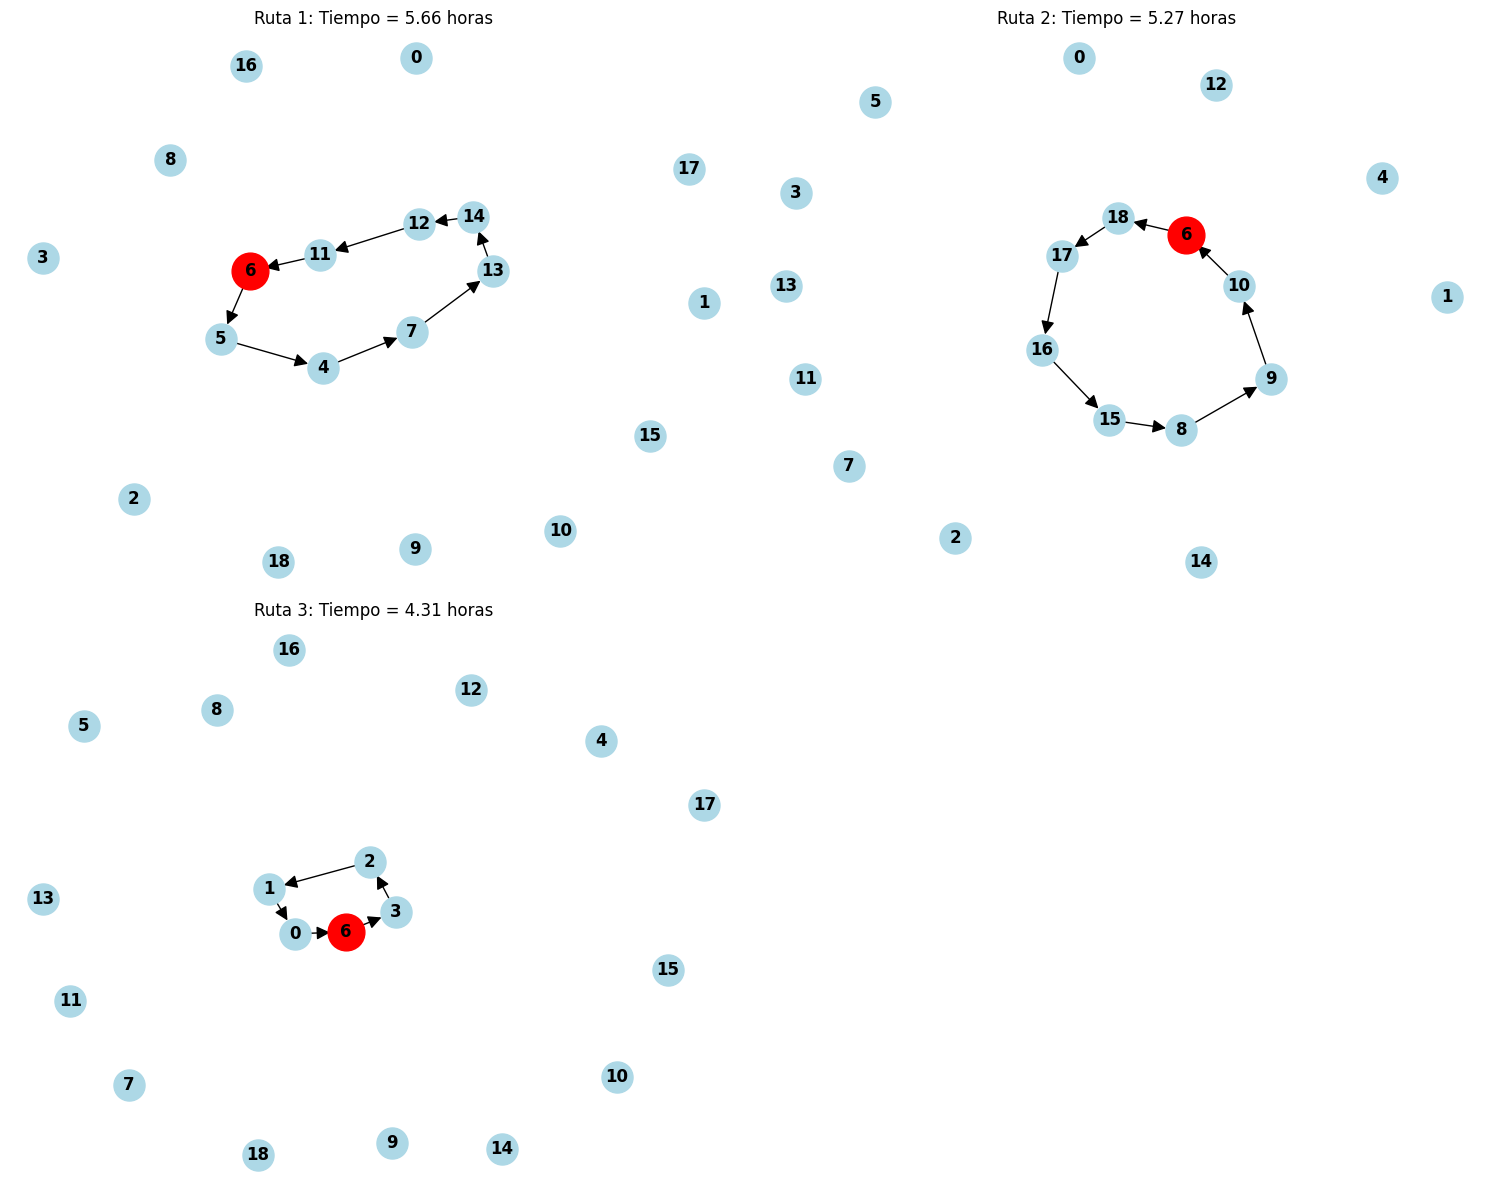

In [14]:
def calculate_route_time(route):
    if len(route) <= 1:
        return 0
    
    total_time = 0
    # Sumar los tiempos de viaje entre polígonos consecutivos
    for i in range(len(route) - 1):
        total_time += dist_poligonos_hrs[route[i], route[i+1]]
    
    # Añadir tiempos de carga/descarga (0.5 hrs por polígono visitado) más 0.5 extra
    # Se resta 2 porque no contamos como paradas el polígono inicial y final si son el mismo
    total_time += 0.5 * (len(route) - 2) + 0.5
    
    return total_time

def generar_ruta_greedy_con_disponibles(poligonos_disponibles):
    ruta = [START_POLYGON]  # Comenzar desde el polígono 6
    tiempo_total = 0.0
    poligonos_no_visitados = poligonos_disponibles.copy() 
    
    while poligonos_no_visitados and len(ruta) < 10:  # Limitar a un máximo de 10 polígonos
        # Encontrar el polígono más cercano al último visitado
        actual = ruta[-1]
        nearest = min(poligonos_no_visitados, key=lambda x: dist_poligonos_hrs[actual, x])
        tiempo_a_siguiente = dist_poligonos_hrs[actual, nearest]
        
        # calcular el tiempo total estimado si se añade este polígono
        # Nueva ruta con el polígono más cercano
        new_route = ruta + [nearest]
        new_time = 0
        
        # Sum travel times
        for i in range(len(new_route) - 1):
            new_time += dist_poligonos_hrs[new_route[i], new_route[i+1]]
            
        # Add loading times + extra 0.5
        new_time += 0.5 * (len(new_route) - 1) + 0.5
        
        # Add anticipated time to return to depot
        return_time = dist_poligonos_hrs[nearest, START_POLYGON]
        total_estimated_time = new_time + return_time
        
        # Check if adding this polygon keeps the route under time limit
        if total_estimated_time <= tiempo_maximo:
            ruta.append(nearest)
            poligonos_no_visitados.remove(nearest)
            tiempo_total = new_time  # Update current time without return trip
        else:
            break
    
    # Add return to starting polygon
    ruta.append(START_POLYGON)
    
    # Calculate final time using the calculate_route_time function to ensure consistency
    tiempo_final = calculate_route_time(ruta)
    
    return ruta, tiempo_final

def generar_multiples_rutas_greedy():
    todas_rutas = []
    poligonos_restantes = [i for i in range(NUM_POLYGONS) if i != START_POLYGON]
    
    while poligonos_restantes:
        # Generate a greedy route with remaining polygons
        ruta, tiempo = generar_ruta_greedy_con_disponibles(poligonos_restantes)
        todas_rutas.append((ruta, tiempo))
        
        # Remove visited polygons from the set of remaining polygons
        for p in ruta[1:-1]:  # Exclude start/end depot
            if p in poligonos_restantes:
                poligonos_restantes.remove(p)
        
        # If we couldn't add any polygons to the route, break to avoid infinite loop
        if len(ruta) <= 2:  # Just start and end nodes
            break
    
    return todas_rutas

# Generate and display all greedy routes
todas_rutas_greedy = generar_multiples_rutas_greedy()

print(f"Se generaron {len(todas_rutas_greedy)} rutas greedy:")
for i, (ruta, tiempo) in enumerate(todas_rutas_greedy):
    print(f"Ruta {i+1}: {ruta}, Tiempo: {tiempo:.2f} horas")

# Total de polígonos visitados
total_poligonos_visitados = sum(len(ruta) - 2 for ruta, _ in todas_rutas_greedy)
print(f"Total de polígonos visitados: {total_poligonos_visitados} de {NUM_POLYGONS-1}")
# Visualize all routes
plt.figure(figsize=(15, 12))
for i, (ruta, tiempo) in enumerate(todas_rutas_greedy):
    plt.subplot(2, 2, i+1 if i < 4 else 4)  # Up to 4 routes in a 2x2 grid
    G = nx.DiGraph()
    
    # Add nodes
    for j in range(NUM_POLYGONS):
        G.add_node(j)
    
    # Add edges in the route
    for j in range(len(ruta) - 1):
        G.add_edge(ruta[j], ruta[j+1], weight=dist_poligonos_hrs[ruta[j], ruta[j+1]])
    
    pos = nx.spring_layout(G, seed=42)  # Fixed seed for consistent layout
    
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=500, arrowsize=20, font_weight='bold')
    
    # Highlight the start/end node
    nx.draw_networkx_nodes(G, pos, nodelist=[START_POLYGON], node_color='red', node_size=700)
    
    plt.title(f"Ruta {i+1}: Tiempo = {tiempo:.2f} horas")
    plt.axis('off')
    
    if i >= 3:  # Only show up to 4 routes in the figure
        break

plt.tight_layout()
plt.show()

## Algoritmo genético para el ruteo (Por hacer)

In [6]:
# Individuos: Lista enteros que corresponden a los poligonos de la ruta max 10 poligonos por ruta
# Criterio inicialización: Aleatorios factibles
# Criterio infactibilidad: Tiempo total de la ruta mayor a 6 horas, elementos repetidos
# Funcion objetivo: Minimizar tiempo total de la ruta
# tiempo ruta = suma de distancias hora entre poligonos + 0.5* numero de poligonos visitados+0.5
# Al final, las rutas deben ser cíclicas, es decir, volver al polígono de inicio
# El conjunto de soluciones factibles es el conjunto de rutas que cumplen con el tiempo máximo y no repiten polígonos y al unirlos contienen a todos los polígonos
# Funcion fitness: 1/tiempo ruta
# Criterio de parada: 100 generaciones, o si no hay mejora en 10 generaciones
# Criterio de selección: Ruleta
# Probabilidad de cruce: 0.8
# Probabilidad de mutación: 0.2
# Tamaño de la población: 30
